# CatBoost Starter for Brain Comp
This is a CatBoost starter notebook for Kaggle's brain comp. We use only spectrogram features. (The model does not use eeg features yet). We can improve the CV and LB score by engineering more (spectrogram and/or eeg) features and we can tune the CatBoost model (and/or use other ML DL models). Discussion about this starter is [here][2].

Kaggleの脳波コンペ用のStarter Notebookである。SpectrogramとEEGを使用（UPDATE済み）。より多くのSpectrogram / EEG特徴量をエンジニアリングすることで、CV / LBスコアを改善できる。CatBoostモデルをほかのモデルと組み合わせることで改善することもできる。


In this notebook, we also compare five CV scores. Kaggle's sample submission uses equal predictions of 1/6 for all targets and achieves CV 1.46, LB 1.09. The best public notebook (on Jan 12th) [here][1] uses train means and achieves CV 1.26 LB 0.97. Our CatBoost model version 1 achieves CV 1.01 LB 0.81. Our CatBoost model version 2 achieves CV 0.82 LB 0.67. Then version 3 adds features from **EEG spectrograms** and achieves CV 0.74, wow! Let's see what LB is...

5つのCVスコアを比較した。サブミッションにおいては、すべての目的変数列（6つ）に対して同じ重みづけ（1/6ずつ）をおこなっている。
    - ver1: CV 1.01, LB 0.81
    - ver2: CV 0.82, LB 0.67
    - ver3: CV 0.74, LB 0.67

# Exciting UPDATE!
Version 3 of this notebook trains using **both** Kaggle spectrograms and my new **EEG spectrograms** from my Kaggle dataset [here][3] (which were created from my spectrogram starter [here][4]). We boost the CV score and (most likely) LB score by almost `+0.10`, wow! 

本Starter Notebookのversion3では、spectrogramとEEG spectrogramの両方を用いてtrainingを行っている。CV, LBが+0.10増加した。


### Version Notes
* Version 1 - Uses spectrogram features from 10 minute window `means`. Achieves CV 1.01, LB 0.81
* Version 2 - Uses spectrogram features from 10 minute and 20 second `means` and `mins`. Achieves CV 0.82, LB 0.67
* Version 3 - Uses Kaggle spectrogrms **plus EEG spectrograms**. Achieves 0.74, LB to be determined...


- Version 1 - 10分の `time window` の平均から得たスペクトログラム特徴量を使用
- Version 2 - 10分と20秒の `time window` の、平均とminから得たスペクトログラム特徴量を使用
- Version 3 - Kaggle スペクトログラムと、EEGスペクトログラムを使用

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467576
[3]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms
[4]: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg

# Load Libraries

In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

VER = 3

# Load Train Data

In [2]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

# Create Non-Overlapping Eeg Id Train Data
The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

データの説明には、テストデータには、同じ `eeg_id` からの複数の crop は含まれていないと記載されている。

したがって、「eeg_id」ごとに 1 つの crop のみを使用してトレーニングおよび検証する。

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [3]:
# EEGデータをeeg_idでグループ化して、前処理と集計をおこなう

# 最初の'spectrogram_id'と最小の'spectrogram_label_offset_seconds'を集計
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

# 最大の'spectrogram_label_offset_seconds'を集計
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

# 'patient_id'を集計
tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

# TARGETSの各列の値をそれぞれ合計
tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
# TARGETSの各列を正規化
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

# 'expert_consensus'を集計
tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

# eeg_idをインデックスから列に戻す
train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


eeg_id     spec_id     min     max  patient_id  seizure_vote  lpd_vote  \
0  568657   789577333     0.0    16.0       20654           0.0  0.000000   
1  582999  1552638400     0.0    38.0       20230           0.0  0.857143   
2  642382    14960202  1008.0  1032.0        5955           0.0  0.000000   
3  751790   618728447   908.0   908.0       38549           0.0  0.000000   
4  778705    52296320     0.0     0.0       40955           0.0  0.000000   

   gpd_vote  lrda_vote  grda_vote  other_vote target  
0      0.25   0.000000   0.166667    0.583333  Other  
1      0.00   0.071429   0.000000    0.071429    LPD  
2      0.00   0.000000   0.000000    1.000000  Other  
3      1.00   0.000000   0.000000    0.000000    GPD  
4      0.00   0.000000   0.000000    1.000000  Other

# Feature Engineer
In this section, we create features for our CatBoost model. 

CatBoostモデルに入れる特徴量を作成する。

First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my [Kaggle dataset][1], set variable `READ_SPEC_FILES = False`. Thanks for upvoting my Kaggle dataset!

まず、11000個の学習用 Spectrogram ファイルを読み込む必要があるが、代わりにCHRIS DEOTTEが自作したデータセットを使う。このデータセットは、11000個の Spectrogramを1分いないに読み込むことができる。このデータをつかうときは、`READ_SPEC_FILES = False`を設定する。

Next we need to engineer features for our CatBoost model. In version 1 notebook, we just take the mean (over time) of each of the 400 spectrogram frequencies (using middle 10 minutes). This produces 400 features (per each unique eeg id). We can improve CV and LB score by engineering new features (and/or tuning CatBoost).

次に、CatBoostモデルの特徴量を設計する。
Version 1について。400個のスペクトログラム周波数の、中間の10秒の時間平均を取得する。これにより、一意のeeg_idごとに400個の特徴量が生成される。


UPDATE: Version 2 creates features from `means` and `mins`. And version 2 uses `10 minute windows` and `20 second windows`.

Version 2について、10分の時間窓 `10 minute windows`と 20秒の時間窓 `20 seconds windows`の、時間平均と時間最小値から特徴量を作成する。

UPDATE: Version 3 uses **both** Kaggle spectrograms and **EEG spectrograms**. We load EEG spectrograms from my Kaggle dataset [here][2]. These EEG spectrograms were created from EEG raw waveforms in my spectrogram starter [here][3]. Thank you everyone for upvoting my new Kaggle dataset!

KaggleスペクトログラムとEEGスペクトログラムの両方を使用する。EEGスペクトログラムは、EEGの生の波形からされた（[コード][3]）。


[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
[2]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms
[3]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57

In [4]:
# Falseのとき、CHRIS DEOTTE氏が作成したデータを利用
READ_SPEC_FILES = False
READ_EEG_SPEC_FILES = False

In [5]:
%%time
# READ ALL SPECTROGRAMS
# スペクトログラムの読み込み
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 3.36 s, sys: 6.29 s, total: 9.65 s
Wall time: 1min 27s


In [6]:
%%time
# READ ALL EEG SPECTROGRAMS
# 生のEEGデータから作成されたEEG スペクトログラムの読み込み
if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 5.56 s, sys: 8.52 s, total: 14.1 s
Wall time: 1min 46s


In [7]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# FEATURE NAMES
# 元の Spectrogram のファイルから、列名を取得
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]             # スペクトログラム: 10分の時間窓の時間平均
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]             # スペクトログラム: 10分の時間窓の時間最小値
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]            # スペクトログラム: 20秒の時間窓の時間平均
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]             # スペクトログラム: 20秒の時間窓の時間最小値
FEATURES += [f'eeg_mean_f{x}_10s' for x in range(512)]      # 脳波: 10分の時間窓の時間平均
FEATURES += [f'eeg_min_f{x}_10s' for x in range(512)]       # 脳波: 10分の時間窓の時間最小値
FEATURES += [f'eeg_max_f{x}_10s' for x in range(512)]       # 脳波: 20秒の時間窓の時間平均
FEATURES += [f'eeg_std_f{x}_10s' for x in range(512)]       # 脳波: 20秒の時間窓の時間平均
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

data = np.zeros((len(train),len(FEATURES)))
for k in range(len(train)):
    if k%100==0: print(k,', ',end='')
    row = train.iloc[k]
    r = int( (row['min'] + row['max'])//4 ) 

    ### スペクトログラム特徴量の計算
    # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
    # 10分時間窓の特徴量計算
    x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,:400] = x
    x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES (MEANS and MINS)
    # 20秒時間窓の特徴量計算
    x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,800:1200] = x
    x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,1200:1600] = x

    ### EEG特徴量の計算
    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    # 10秒時間窓の特徴量の計算（mean, min, max, std）
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

train[FEATURES] = data
print(); print('New train shape:',train.shape)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.44 µs
We are creating 3648 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 

In [8]:
# FREE MEMORY
del all_eegs, spectrograms, data
gc.collect()

0

# Train CatBoost
We use the default settings for CatBoost which are pretty good. We can tune CatBoost manually to improve CV and LB score. Note that CatBoost will automatically use both Kaggle T4 GPUs (when we add parameter `task_type='GPU'`)  for super fast training!

CatBoost には非常に優れたデフォルト設定を使用している。 CatBoost を手動で調整して、CV および LB スコアを改善できる。
CatBoost は、超高速トレーニングのために (パラメーター `task_type='GPU'` を追加すると) 両方の Kaggle T4 GPU を自動的に使用する。

In [9]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import json

all_oof = []
all_true = []
# Target変数のラベルの定義
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}


gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = CatBoostClassifier(task_type='GPU',
                               loss_function='MultiClass')
    
    # trainデータ / validデータのPoolを作成
    train_pool = Pool(
        data = train.loc[train_index,FEATURES],
        label = train.loc[train_index,'target'].map(TARS),
    )
    
    valid_pool = Pool(
        data = train.loc[valid_index,FEATURES],
        label = train.loc[valid_index,'target'].map(TARS),
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    
    # モデルの保存
    model.save_model(f'CAT_v{VER}_f{i}.cat')

    # モデルのパラメータの保存
    params = model.get_all_params()
    with open(f'CAT_v{VER}_f{i}_params.txt', 'w') as f:
        json.dump(params, f)

    # 各 fold の予測確率
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)   # 全validationデータに対する予測確率
all_true = np.concatenate(all_true) # 全validationデータのターゲット変数の実測値

# Feature Importance
Below we display the CatBoost top 25 feature importance for the last fold we trained.

feature importance 上位25件

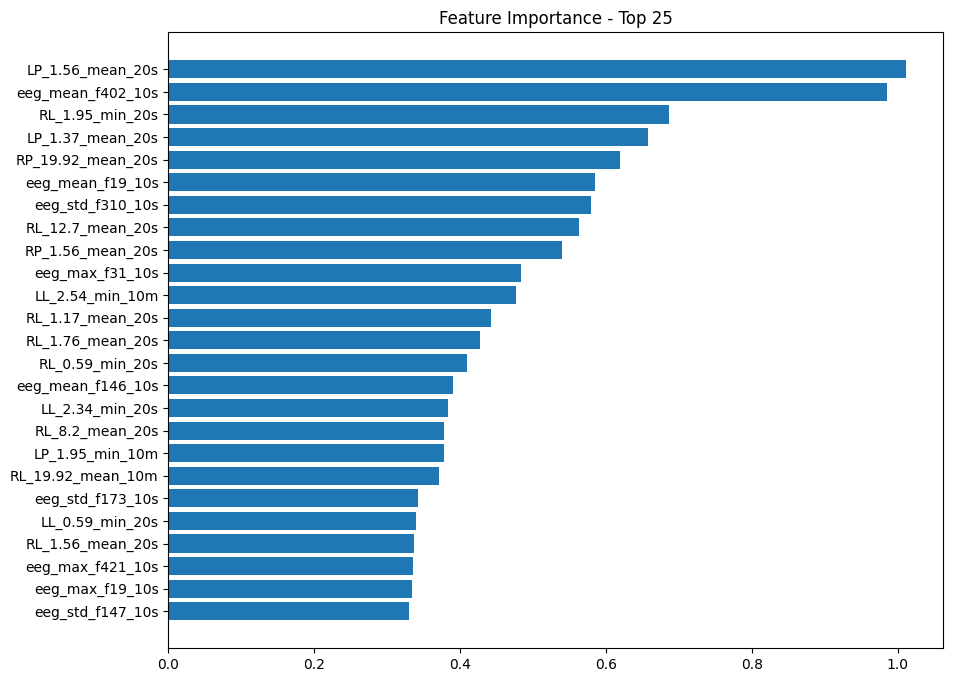

In [11]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# CV Score for CatBoost
This is CV score for our CatBoost model.

In [12]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

# CV Score KL-Divの保存
with open(f'CV_Score_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score KL-Div for CatBoost = 0.7443178053099727


# CV Score for Preds 1/6
This is CV score for Kaggle's sample submission.csv which uses equal predictions of 1/6 for all targets.

各目的変数の重みをすべて 1/6 にしたときのCVスコア

In [13]:
oof = pd.DataFrame(all_oof.copy())
for c in oof.columns:
    oof[c] = 1/6.
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score for "Use Equal Preds 1/6" =',cv)

# CV Score for "Use Equal Preds 1/6"の保存
with open(f'CV_Score_USE_EQUAL_PREDS_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score for "Use Equal Preds 1/6" = 1.4563246139800803


# CV Score for EEG_Id Means
This is CV score for current highest scoring public notebook [here][1] which uses train means as predictions.

学習データのmeanを用いたCVスコア

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv

In [14]:
all_oof2 = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    #print('#'*25)
    #print(f'### Fold {i+1}')
        
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    
    #print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    #print('#'*25)
        
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
all_oof2 = np.concatenate(all_oof2)

In [15]:
oof = pd.DataFrame(all_oof2.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score for "Use Train Means" =',cv)

# CV Score for "Use Equal Preds 1/6"の保存
with open(f'CV_Score_EEG_ID_MEANS_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score for "Use Train Means" = 1.2641160568651757
